# Binary outcome Classification Model of H1-B Visa Petition Data 2011 -2016 
___
+ GOAL : TO PREDICT THE OUTCOME OF AN EMPLOYER VISA PETITION APPLICATION BASED ON FEATURES     
1) EMPLOYER_NAME < _Decision Tree Classifier ignores this features, Highly branching_ >  
2) JOB-TITLE   
3) FULL_TIME_POSITION  
4) PREVAILING_WAGE  
5) YEAR  
6) WORKSITE  
___
** I realised that the goal of this model is to predict the outcome of the petition process. The outcomes we were looking at previously were POSITIVE -> [CERTIFIED], NEGATIVE -> [CERTIFIED WITHDRAWN, DENIED, WITHDRAWN]. However i realised that the actual problem can be solved by focusing on ___TWO OUTCOMES : CERTIFIED and DENIED___ where CERTFIED-WITHDRAWN is considered as CERTIFIED because that petition was approved and later withdrawn. The actual outcome of the petition process was CERTIFIED, it just changed later so we will reflect this. ** 
___
**Secondly we will remove the instances where the outcome is withdrawn because these petitions did not go through the whole process to an outcome of CERTIFIED and denied. **
___
**This will leave us with a Binary outcome of CERTIFIED or DENIED**

In [1]:
%pylab inline
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import matplotlib.ticker as mtick
from scipy import stats
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## Read In Data

In [2]:
filePath = "./Data/h1b_kaggle.csv"
df = pd.read_csv(filePath, header=0)

## Data Cleaning and Preprocessing
___

** Tasks ** 
___
1) Remove features we do not need  
2) Remove instances with missing feature values  
3) Remove instances where the outcome is " WITHDRAWN "  
4) Change the outcome "CERTIFIED-WITHDRAWN" to " CERTIFIED "  
5) Remove outliers  
6) Change PREVAILING WAGE and YEAR values to int  
7) Need to select 20,000 instances to sample  
8) Encode categorical features  
    a) EMPLOYER_NAME  
    b) JOB_TITLE  
    c) FULL_TIME_POSITION  
    d) WORKSITE  
    ___Note : Year and Prevailing wage are int64 data type___  

In [3]:
# 1) Remove features we do not need 
# Drop unnecessary features
try:
    df.drop(['Unnamed: 0', 'lon', 'lat', 'SOC_NAME'], axis=1, inplace=True)
except ValueError:
    print("Already deleted unnecessary features")
original_number_of_instances = len(df)

In [4]:
# 2) Remove instances with missing feature values
df.dropna(inplace=True)

In [5]:
# 3) Remove instances where outcome is not CERTIFIED | CERTIFIED-WITHDRAWN | DENIED
certified = df["CASE_STATUS"] == "CERTIFIED"
certified_withdrawn = df["CASE_STATUS"] == "CERTIFIED-WITHDRAWN"
denied = df["CASE_STATUS"] == "DENIED"

df = df[certified | certified_withdrawn | denied ]

In [6]:
# 4) Change the outcome "CERTIFIED-WITHDRAWN" to " CERTIFIED "

def convert_certified_withdrawn(x):
    ''' Convert outcome CASE_STATUS to CERTIFED where it is CERTIFIED_WITHDRAWN'''
    if x == 'CERTIFIED-WITHDRAWN':
        x = 'CERTIFIED'
    return x

df["CASE_STATUS"] = df["CASE_STATUS"].apply(convert_certified_withdrawn)

In [7]:
# 5) Remove outliers
df = df[~(np.abs(df["PREVAILING_WAGE"] - df["PREVAILING_WAGE"].mean()) > (2 * df["PREVAILING_WAGE"].std()))]

In [8]:
# 6) Change PREVAILING_WAGE and YEAR values to ints
def transform_to_int(x):
    return int(x)

df['PREVAILING_WAGE'] = df["PREVAILING_WAGE"].apply(transform_to_int)
df['YEAR'] = df["YEAR"].apply(transform_to_int)

# Data Preprocessing

In [9]:
# 7) Select 20, 000 instances with replacement
# df.take() uses positions to select instances
df2 = df.take(np.random.permutation(len(df)))[:20000]

In [10]:
len(df2)

20000

In [11]:
#8) Encode categorical features
cols_list = list(df2.columns)
s = " + ".join([item for item in cols_list if (item != "CASE_STATUS" and item != "PREVAILING_WAGE" and item != "YEAR")])
print(s)

EMPLOYER_NAME + JOB_TITLE + FULL_TIME_POSITION + WORKSITE


In [12]:
X_cat = df2[["EMPLOYER_NAME", "JOB_TITLE", "FULL_TIME_POSITION", "WORKSITE"]]
X_num = df2[["PREVAILING_WAGE", "YEAR"]]
y = df2["CASE_STATUS"]

In [13]:
X_cat[:2]

,EMPLOYER_NAME,JOB_TITLE,FULL_TIME_POSITION,WORKSITE
2364376,UNIVERSITY OF COLORADO,PROFESSIONAL RESEARCH ASSISTANT,Y,"AURORA, COLORADO"
541876,"OPTIMAL CAE, INC.",PROJECT ENGINEER,Y,"DEARBORN, MICHIGAN"


In [14]:
X_num[:2]

,PREVAILING_WAGE,YEAR
2364376,28080,2012
541876,81994,2016


In [15]:
y[:2]

2364376    CERTIFIED
541876     CERTIFIED
Name: CASE_STATUS, dtype: object

In [16]:
X_cat.dtypes

EMPLOYER_NAME         object
JOB_TITLE             object
FULL_TIME_POSITION    object
WORKSITE              object
dtype: object

In [17]:
# Encode the categorical features
import patsy

In [18]:
X_cat_encoded = patsy.dmatrix(s, X_cat, return_type='dataframe')

In [19]:
X_cat_encoded[:2]

,Intercept,"EMPLOYER_NAME[T.1-STOP TRANSLATION USA, LLC]",EMPLOYER_NAME[T.1010DATA SERVICES LLC],EMPLOYER_NAME[T.1111 SW 1 AVE LLC],EMPLOYER_NAME[T.180LA],"EMPLOYER_NAME[T.180LA, LLC]",EMPLOYER_NAME[T.18|8 SOLUTIONS INC.],EMPLOYER_NAME[T.1ST VERSION INC],"EMPLOYER_NAME[T.1STDIBS.COM, INC.]","EMPLOYER_NAME[T.1WORLD ONLINE, INC.]",...,"WORKSITE[T.YELM, WASHINGTON]","WORKSITE[T.YORK, PENNSYLVANIA]","WORKSITE[T.YORKTOWN HEIGHTS, NEW YORK]","WORKSITE[T.YOUNGSTOWN, OHIO]","WORKSITE[T.YOUNGSVILLE, LOUISIANA]","WORKSITE[T.YPSILANTI, MICHIGAN]","WORKSITE[T.YUMA, ARIZONA]","WORKSITE[T.ZEELAND, MICHIGAN]","WORKSITE[T.ZION, ILLINOIS]","WORKSITE[T.ZUNI, NEW MEXICO]"
2364376,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
541876,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
X = X_cat_encoded[:]
X[["PREVAILING_WAGE", "YEAR"]] = X_num

In [21]:
X[:2]

,Intercept,"EMPLOYER_NAME[T.1-STOP TRANSLATION USA, LLC]",EMPLOYER_NAME[T.1010DATA SERVICES LLC],EMPLOYER_NAME[T.1111 SW 1 AVE LLC],EMPLOYER_NAME[T.180LA],"EMPLOYER_NAME[T.180LA, LLC]",EMPLOYER_NAME[T.18|8 SOLUTIONS INC.],EMPLOYER_NAME[T.1ST VERSION INC],"EMPLOYER_NAME[T.1STDIBS.COM, INC.]","EMPLOYER_NAME[T.1WORLD ONLINE, INC.]",...,"WORKSITE[T.YORKTOWN HEIGHTS, NEW YORK]","WORKSITE[T.YOUNGSTOWN, OHIO]","WORKSITE[T.YOUNGSVILLE, LOUISIANA]","WORKSITE[T.YPSILANTI, MICHIGAN]","WORKSITE[T.YUMA, ARIZONA]","WORKSITE[T.ZEELAND, MICHIGAN]","WORKSITE[T.ZION, ILLINOIS]","WORKSITE[T.ZUNI, NEW MEXICO]",PREVAILING_WAGE,YEAR
2364376,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28080,2012
541876,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81994,2016


In [22]:
# 8 ) Split the Data
# Train - 80 percent 
# Test - 20 percent 
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
sss

StratifiedShuffleSplit(n_splits=10, random_state=0, test_size=0.2,
            train_size=None)

In [23]:
X_vals = X.values
y_vals = y.values

In [24]:
for train_index, test_index in sss.split(X_vals, y_vals):
    X_train, X_test = X_vals[train_index], X_vals[test_index]
    y_train, y_test = y_vals[train_index], y_vals[test_index]

In [25]:
X_train_len  = len(X_train)
X_test_len  = len(X_test)
y_train_len  = len(y_train)
y_test_len  = len(y_test)

print("X_train number of instance : {}".format(X_train_len))
print("X_test number of instance : {}".format(X_test_len))
print("y_train number of instance : {}".format(y_train_len))
print("y_test number of instance : {}".format(y_test_len))

X_train number of instance : 16000
X_test number of instance : 4000
y_train number of instance : 16000
y_test number of instance : 4000


In [26]:
y.value_counts()

CERTIFIED    19375
DENIED         625
Name: CASE_STATUS, dtype: int64

In [27]:
# y = y.apply(convert_certified_withdrawn)
# y.value_counts()

# Modeling

## K-Nearest Neighbours Classifier

In [28]:
neigh = KNeighborsClassifier(n_neighbors=3)
k_nearest_cls = neigh.fit(X_train, y_train)

In [29]:
predicted = neigh.predict(X_test)

## Evaluation of classifier

In [30]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import roc_auc_score

### Classification Report
---

In [31]:
y_true = y_test[:]
y_pred = predicted[:]
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

  CERTIFIED       0.97      1.00      0.98      3875
     DENIED       0.17      0.02      0.03       125

avg / total       0.94      0.97      0.95      4000



### Accuracy Score

In [32]:
print("Normalized Accuracy Score : {:.3f} ".format(accuracy_score(y_true, y_pred)))
print("Correctly Classified {:d} out of {} instance".format(accuracy_score(y_true, 
                                                                           y_pred, 
                                                                           normalize=False), 
                                                                           len(y_test)))

Normalized Accuracy Score : 0.967 
Correctly Classified 3867 out of 4000 instance


+ This is actually misleading. The number of TP is high but the number of TN are not high. 

#### Precision Score
___
The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
The best value is 1 and the worst value is 0.

In [33]:
classifier_p_score = precision_score(y_true, y_pred, pos_label="CERTIFIED")
print("Precision score is {:.2f}".format(classifier_p_score))

Precision score is 0.97


#### Recall Score
___
The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples. The best value is 1 and the worst value is 0.

In [34]:
classifier_r_score_w = recall_score(y_true, y_pred, average='weighted')
print("Recall Score is {:.2f}".format(classifier_r_score_w))

Recall Score is 0.97


#### Confusion Matrix
___

In [35]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [36]:
confusion_matrix(y_true, y_pred)

array([[3865,   10],
       [ 123,    2]])

In [37]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
class_names = ['CERTIFIED','DENIED']

Confusion matrix, without normalization
[[3865   10]
 [ 123    2]]


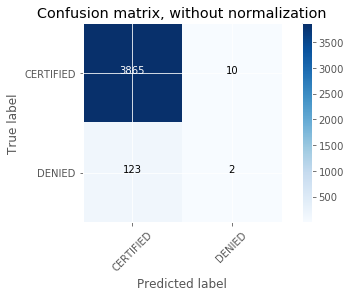

In [38]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')


Normalized confusion matrix
[[ 1.    0.  ]
 [ 0.98  0.02]]


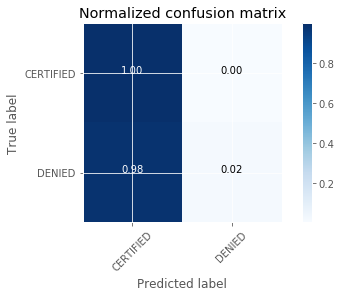

In [39]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions

From this confusion matrix we can see that, the instances that are actually denied are predicted as certified. This is a high number of false positives
___
This means this model is good at predicting TP outcomes. In other words good at predicting outcomes where the  petion application is certified. But it is not good at predicting outcome is negative. This is reflected in the high number of [FP] 

#### ROC Curve
___


In [40]:
y_score = k_nearest_cls.predict_proba(X_test)

In [41]:
fpr, tpr, thresholds = roc_curve(y_true, y_score[:,1], pos_label='CERTIFIED')

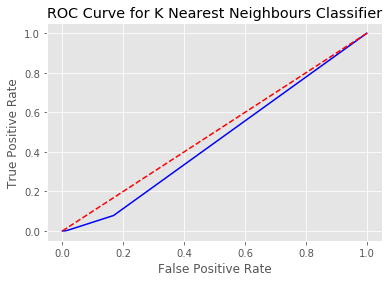

In [42]:
plt.plot(fpr, tpr, 'b-')
plt.plot([0, 1], [0, 1], 'r--')
plt.title("ROC Curve for K Nearest Neighbours Classifier")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()

+ The red line reflects the perfomance of a random classifier, this shows that that this model's performance is poor such that it is even a random classifier would have a slightly better performance

#### Precision Recall Curve
___

In [43]:
precision, recall, threshold = precision_recall_curve(y_true, y_score[:,1], pos_label='CERTIFIED')
precision2, recall2, threshold2 = precision_recall_curve(y_true, y_score[:,0], pos_label='CERTIFIED')

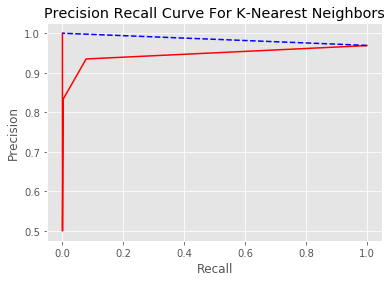

In [44]:
plt.figure()
plt.plot(recall, precision, 'r-')
plt.plot(recall2, precision2, 'b--')
plt.title("Precision Recall Curve For K-Nearest Neighbors")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

+ This curve is wierd. Something might be off 

# Gaussian Naive Bayes classifier

In [45]:
from sklearn.naive_bayes import GaussianNB

In [46]:
gnb = GaussianNB()

In [47]:
gnb_cls = gnb.fit(X_train, y_train)
y_pred_bayes = gnb_cls.predict(X_test)

## Evaluation of Gaussian Naive Bayes Classifier

#### Classification Report

In [48]:
print(classification_report(y_test, y_pred_bayes))

             precision    recall  f1-score   support

  CERTIFIED       0.97      0.99      0.98      3875
     DENIED       0.13      0.04      0.06       125

avg / total       0.94      0.96      0.95      4000



#### Confusion Matrix

In [49]:
confusion_matrix(y_test, y_pred_bayes)

array([[3841,   34],
       [ 120,    5]])

In [50]:
# Compute confusion matrix
cnf_matrix_bayes = confusion_matrix(y_test, y_pred_bayes)
np.set_printoptions(precision=2)
class_names = ['CERTIFIED','DENIED']

Confusion matrix, without normalization
[[3841   34]
 [ 120    5]]


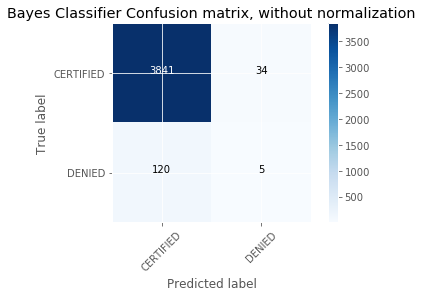

In [51]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_bayes, classes=class_names,
                      title='Bayes Classifier Confusion matrix, without normalization')

Normalized confusion matrix
[[ 0.99  0.01]
 [ 0.96  0.04]]


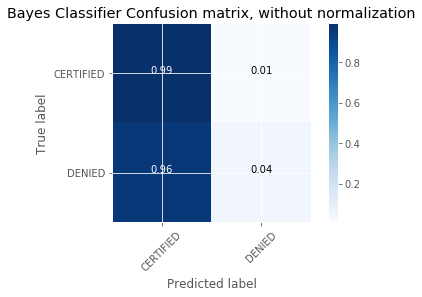

In [52]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_bayes, classes=class_names,
                      title='Bayes Classifier Confusion matrix, without normalization', normalize=True)

#### Accuracy Report
___

In [53]:
print("Normalized Accuracy Score : {:.3f} ".format(accuracy_score(y_true, y_pred_bayes)))
print("Correctly Classified {:d} out of {} instance".format(accuracy_score(y_true, 
                                                                           y_pred, 
                                                                           normalize=False), 
                                                                           len(y_test)))

Normalized Accuracy Score : 0.962 
Correctly Classified 3867 out of 4000 instance


#### Pecision Score

#### Recall Score

In [54]:
y_score_bayes = gnb_cls.predict_proba(X_test)

#### ROC Curve

In [55]:
fpr_bayes, tpr_bayes, thresholds_roc_baye = roc_curve(y_true, y_score_bayes[:,1], pos_label='CERTIFIED')

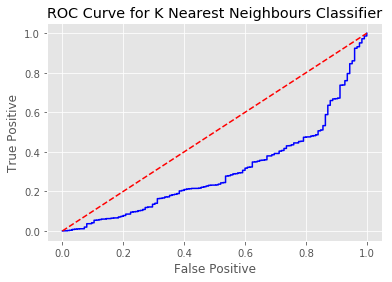

In [56]:
plt.plot(fpr_bayes, tpr_bayes, 'b-')
plt.plot([0, 1], [0, 1], 'r--')
plt.title("ROC Curve for K Nearest Neighbours Classifier")
plt.ylabel("True Positive")
plt.xlabel("False Positive")
plt.show()

This classifier performs even worse than K nearest neighbours, This is primarily because it tends to generate more [FN] than K-nearest neighbours. Once again i think this is because in training CERTIFIED outcomes are over sampled

#### Precision - Recall Curve

In [57]:
precision_bayes, recall_bayes, threshold_pr_bayes = precision_recall_curve(y_true, y_score_bayes[:,1], pos_label='CERTIFIED')

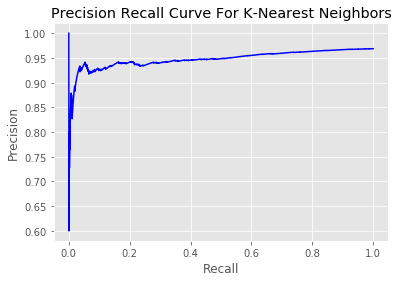

In [58]:
plt.plot(recall_bayes, precision_bayes, 'b-')
plt.title("Precision Recall Curve For K-Nearest Neighbors")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

In [59]:
# Probability of "DENIED" class 
gnb_cls.class_prior_[1]

0.03125

In [60]:
# Probability of "CERTIFIED" class 
gnb_cls.class_prior_[0]

0.96875

- This is why we have such a high number of FP and a low number of TN ... the probability of getting a positive outcome is so high compared to the probability of getting a negative outcome

## Clearly we have a problem of representation in the training set. Consider measures to address imbalance data
___
We can use smote to over sample the minority class so that we have 50 percent probability for a new instance being predicted CERTIFIED or DENIED 

In [61]:
from imblearn.over_sampling import SMOTE

#### Resample using SMOTE to compersate for under sampling of DENIED outcome instances
___

In [62]:
X_train_resampled, y_train_resampled = SMOTE(kind='borderline1').fit_sample(X_train, y_train)

#### Run bayes classifier again
___

In [63]:
# X_train_resampled, y_train_resampled = SMOTE(kind='svm').fit_sample(X_train, y_train)
# Re train gaussian classifier
gnb_smote_cls = gnb.fit(X_train_resampled, y_train_resampled)
y_pred_bayes_smote = gnb_smote_cls.predict(X_test)

# Probability of "CERTIFIED" class 
gnb_smote_cls.class_prior_[0]

0.5

In [64]:
# Probability of "DENIED" class 
gnb_smote_cls.class_prior_[1]

0.5

#### Evaluation of bayes classifier with SMOTE
___

#### Classification Report
___

In [65]:
print(classification_report(y_test, y_pred_bayes_smote))

             precision    recall  f1-score   support

  CERTIFIED       0.97      0.96      0.96      3875
     DENIED       0.07      0.10      0.08       125

avg / total       0.94      0.93      0.94      4000



#### Accuracy Report
___

In [66]:
print("Normalized Accuracy Score : {:.3f} ".format(accuracy_score(y_true, y_pred_bayes_smote)))
print("Correctly Classified {:d} out of {} instance".format(accuracy_score(y_true, 
                                                                           y_pred_bayes_smote, 
                                                                           normalize=False), 
                                                                           len(y_test)))

Normalized Accuracy Score : 0.931 
Correctly Classified 3723 out of 4000 instance


#### Recall Score 
___

In [67]:
bayes_cls_r_score_smote = recall_score(y_true, y_pred_bayes_smote, pos_label="CERTIFIED")
print("Recall Score is {:.2f}".format(bayes_cls_r_score_smote ))

Recall Score is 0.96


#### Precision Score
___

In [68]:
cls_p_score_bayes_smote = precision_score(y_true, y_pred_bayes_smote, pos_label="CERTIFIED")
print("Precision score is {:.2f}".format(cls_p_score_bayes_smote))

Precision score is 0.97


#### ROC Curve
___

In [69]:
y_score_bayes_smote = gnb_smote_cls.predict_proba(X_test)

In [70]:
fpr_bayes_smote, tpr_bayes_smote, thresholds_roc_bayes_smote = roc_curve(y_true, 
                                                                         y_score_bayes_smote[:,1], 
                                                                         pos_label='CERTIFIED')

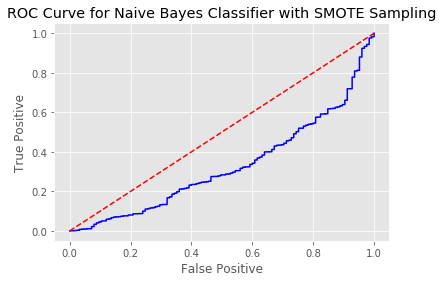

In [71]:
plt.plot(fpr_bayes_smote, tpr_bayes_smote, 'b-')
plt.plot([0, 1], [0, 1], 'r--')
plt.title("ROC Curve for Naive Bayes Classifier with SMOTE Sampling")
plt.ylabel("True Positive")
plt.xlabel("False Positive")
plt.show()

#### Precision Recall Curve
___

In [72]:
precision_bayes_smote, recall_bayes_smote, threshold_pr_bayes = precision_recall_curve(y_true, 
                                                                                       y_score_bayes_smote[:,1], 
                                                                                       pos_label='CERTIFIED')

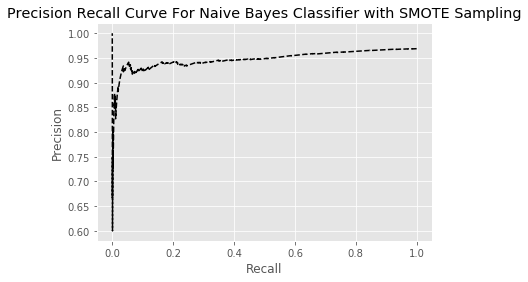

In [73]:
plt.plot(recall_bayes, precision_bayes, 'k--')
plt.title("Precision Recall Curve For Naive Bayes Classifier with SMOTE Sampling")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

** When we use SMOTE to handle imbalanced data. The performance of classification does not improve significantly. Maybe we need to perform dimension reduction. Or increase the amount of training data used**

# Apply dimension reduction to improve performance of models
___

In [74]:
from sklearn.decomposition import PCA

In [75]:
# global centering 
X_centered = X - X.mean()

# decomposition
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_centered)

In [76]:
sss = StratifiedShuffleSplit(n_splits=15, test_size=0.1, random_state=0)
sss

StratifiedShuffleSplit(n_splits=15, random_state=0, test_size=0.1,
            train_size=None)

In [77]:
X_pca.shape

(20000, 20)

In [78]:
for train_index, test_index in sss.split(X_pca, y_vals):
    X_pca_train, X__pca_test = X_pca[train_index], X_pca[test_index]
    y_pca_train, y_pca_test = y_vals[train_index], y_vals[test_index]

In [79]:
y_pca_train.shape

(18000,)

In [80]:
# Use smort to make sure we sample unbalance data in outcomes
X_train_resampled_pca, y_train_resampled_pca = SMOTE(kind='borderline1').fit_sample(X_pca_train, y_pca_train)

In [81]:
# Train Bayes classifier again
gnb_smote_cls_pca = gnb.fit(X_train_resampled_pca, y_train_resampled_pca)

In [82]:
# Get predicted results for X_test_pca so we can evaluate them
y_pred_bayes_smote_pca = gnb_smote_cls_pca.predict(X__pca_test)

In [83]:
# Evaluate classifier with classification report
print(classification_report(y_pca_test, y_pred_bayes_smote_pca))

             precision    recall  f1-score   support

  CERTIFIED       0.97      1.00      0.98      1937
     DENIED       0.50      0.03      0.06        63

avg / total       0.95      0.97      0.95      2000



In [84]:
# Evaluate classifier with accuracy score 
print("Normalized Accuracy Score : {:.3f} ".format(accuracy_score(y_pca_test, y_pred_bayes_smote_pca)))
print("Correctly Classified {:d} out of {} instance".format(accuracy_score(y_pca_test, 
                                                                           y_pred_bayes_smote_pca, 
                                                                           normalize=False), 
                                                                           len(y_test)))

Normalized Accuracy Score : 0.969 
Correctly Classified 1937 out of 4000 instance


In [85]:
# Evaluate classifier with recal score 
bayes_cls_r_score_smote_pca = recall_score(y_pca_test, y_pred_bayes_smote_pca, pos_label="CERTIFIED")
print("Recall Score is {:.2f}".format(bayes_cls_r_score_smote_pca ))

Recall Score is 1.00


In [86]:
cls_p_score_bayes_smote_pca = precision_score(y_pca_test, y_pred_bayes_smote_pca, pos_label="CERTIFIED")
print("Precision score is {:.2f}".format(cls_p_score_bayes_smote))

Precision score is 0.97


In [87]:
y_score_bayes_smote_pca = gnb_smote_cls_pca.predict_proba(X__pca_test)

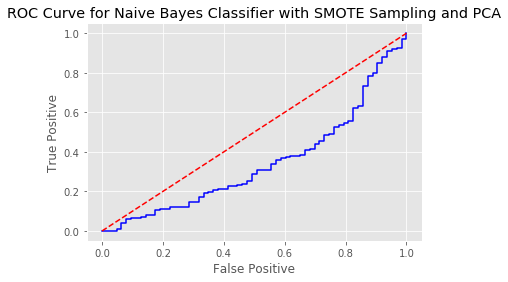

In [88]:
# Evaluate classifier using and ROC Curve
fpr_bayes_smote_pca, tpr_bayes_smote_pca, thresholds_roc_bayes_smote_pca = roc_curve(y_pca_test, 
                                                                         y_score_bayes_smote_pca[:,1], 
                                                                         pos_label='CERTIFIED')
plt.plot(fpr_bayes_smote_pca, tpr_bayes_smote_pca, 'b-')
plt.plot([0, 1], [0, 1], 'r--')
plt.title("ROC Curve for Naive Bayes Classifier with SMOTE Sampling and PCA")
plt.ylabel("True Positive")
plt.xlabel("False Positive")
plt.show()

In [89]:
# Evaluate classifier using Precision - Recall Curve 
precision_bayes_smote_pca, recall_bayes_smote_pca, threshold_pr_bayes_pca = precision_recall_curve(y_pca_test, 
                                                                                       y_score_bayes_smote_pca[:,1], 
                                                                                       pos_label='CERTIFIED')

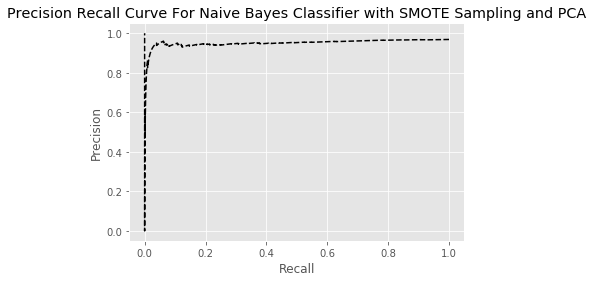

In [90]:
plt.plot(recall_bayes_smote_pca, precision_bayes_smote_pca, 'k--')
plt.title("Precision Recall Curve For Naive Bayes Classifier with SMOTE Sampling and PCA")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

In [91]:
# Evaluate classifier with Confusion Matrix
confusion_matrix(y_pca_test, y_pred_bayes_smote_pca)

array([[1935,    2],
       [  61,    2]])

In [92]:
# Compute confusion matrix
cnf_matrix_bayes_smort_pca = confusion_matrix(y_pca_test, y_pred_bayes_smote_pca)
np.set_printoptions(precision=2)
class_names = ['CERTIFIED','DENIED']

Confusion matrix, without normalization
[[1935    2]
 [  61    2]]


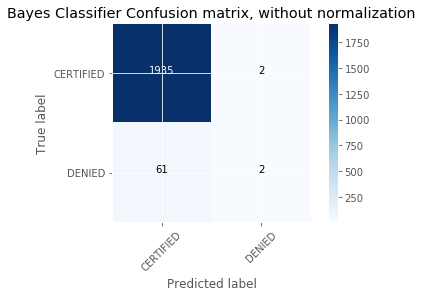

In [93]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_bayes_smort_pca, classes=class_names,
                      title='Bayes Classifier Confusion matrix, without normalization')

Normalized confusion matrix
[[ 1.    0.  ]
 [ 0.97  0.03]]


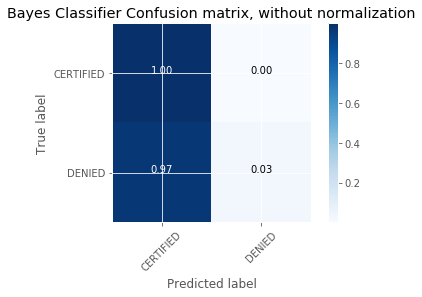

In [94]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_bayes_smort_pca, classes=class_names,
                      title='Bayes Classifier Confusion matrix, without normalization',
                      normalize=True)

    At first i ran this pca with 10 components and the performance only inmproved slightly with the model increasing the number of TN observed but this also brought about an increase in FN, i suspect that SMOTE was able to increase the probability of an instance being classified as DENIED. 
    By increasing the training data size and increasing the number of components retained to 20. Also increasing the number of splits of the stratified shuffle we notice an better performance at observing TN's 

# Decision Tree Classifier
___

In [95]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz # for our classification model

In [99]:
d_clf = DecisionTreeClassifier(criterion='entropy', max_features='auto')
d_clf

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [100]:
# Train model 
decision_clf = d_clf.fit(X_train_resampled_pca, y_train_resampled_pca)

In [101]:
import graphviz

In [103]:
# Visualize tree
# dot_data = export_graphviz(decision_clf,
#                           out_file=None,
#                           filled=True,
#                           impurity=True,
#                           rounded=True,
#                           special_characters=False)
# graph = graphviz.Source(dot_data)
# graph.render("H1-B Petitions SMOTE and PCA Decision Tree")

'H1-B Petitions SMOTE and PCA Decision Tree.pdf'

In [104]:
# Get predicted Values
y_pred_dt_smote_pca  = decision_clf.predict(X__pca_test)

### Evaluation of Decision Tree Classifier

** Confusion Matrix **
____


In [105]:
# Evaluate classifier with Confusion Matrix
confusion_matrix(y_pca_test, y_pred_dt_smote_pca)

array([[1825,  112],
       [  58,    5]])

In [106]:
# Compute confusion matrix
cnf_matrix_dt_smort_pca = confusion_matrix(y_pca_test, y_pred_dt_smote_pca)
np.set_printoptions(precision=2)
class_names = ['CERTIFIED','DENIED']

Confusion matrix, without normalization
[[1825  112]
 [  58    5]]


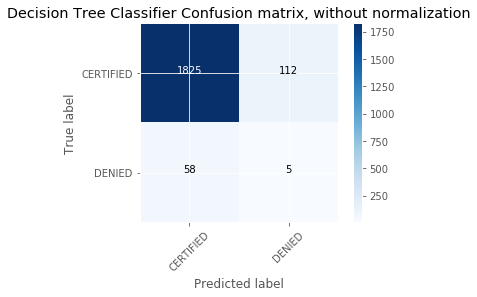

In [108]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_dt_smort_pca, classes=class_names,
                      title='Decision Tree Classifier Confusion matrix, without normalization')

Normalized confusion matrix
[[ 0.94  0.06]
 [ 0.92  0.08]]


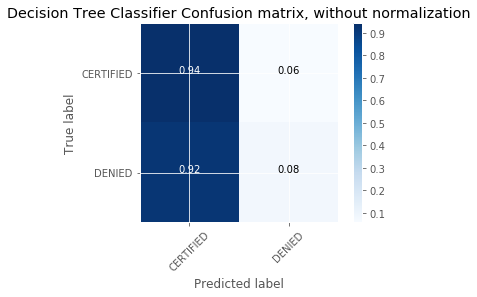

In [109]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_dt_smort_pca, classes=class_names,
                      title='Decision Tree Classifier Confusion matrix, without normalization',
                     normalize=True)

** Classification Report **
___


In [126]:
# Evaluate classifier with classification report
print(classification_report(y_pca_test, y_pred_dt_smote_pca))

             precision    recall  f1-score   support

  CERTIFIED       0.97      0.94      0.96      1937
     DENIED       0.04      0.08      0.06        63

avg / total       0.94      0.92      0.93      2000



** Precision and Recall Score **  
** Precision : Measure of relavance of results returned. High Precision, Low FP **  
** Recall : How many truly relavant results are returned. High Recall, Low FN **

In [127]:
cls_p_score_dt_smote_pca = precision_score(y_pca_test, y_pred_dt_smote_pca, pos_label="CERTIFIED")
print("Precision score is {:.2f}".format(cls_p_score_dt_smote_pca))

cls_r_score_dt_smote_pca = recall_score(y_pca_test, y_pred_dt_smote_pca, pos_label="CERTIFIED")
print("Recall Score is {:.2f}".format(cls_r_score_dt_smote_pca ))


Precision score is 0.97
Recall Score is 0.94


** ROC Curve **
___

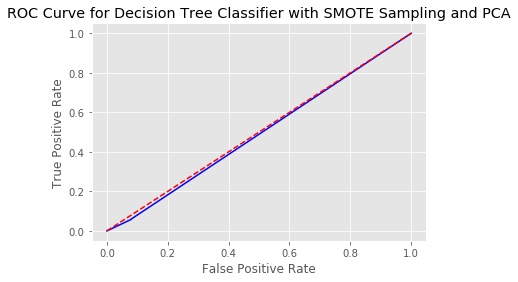

In [125]:
y_score_dt_smote_pca = decision_clf.predict_proba(X__pca_test)

# Evaluate classifier using and ROC Curve
fpr_dt_smote_pca, tpr_dt_smote_pca, thresholds_roc_dt_smote_pca = roc_curve(y_pca_test, 
                                                                         y_score_dt_smote_pca[:,1], 
                                                                         pos_label='CERTIFIED')


plt.plot(fpr_dt_smote_pca, tpr_dt_smote_pca, 'b-')
plt.plot([0, 1], [0, 1], 'r--')
plt.title("ROC Curve for Decision Tree Classifier with SMOTE Sampling and PCA")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

    Here we can see that this decision tree classifier, has similar performance as a simple random classifier shown by the red line. This is better performance than the Naive Bayes classifier with SMOTE and PCA

** Precision Recall Curve **

In [120]:
dt_precision, dt_recall, dt_threshold = precision_recall_curve(y_pca_test, 
                                                               y_score_dt_smote_pca[:,1],
                                                               pos_label="CERTIFIED")

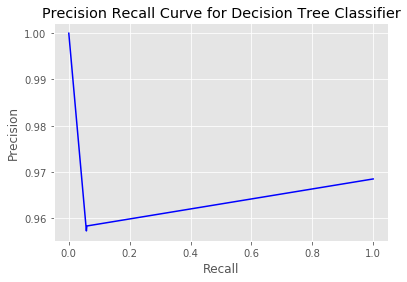

In [122]:
plt.plot(dt_recall, dt_precision, 'b-')
plt.title("Precision Recall Curve for Decision Tree Classifier")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

    The precision-recall curve shows the tradeoff between precision and recall for different threshold

# Leverage Multiple classifiers : Random Forest

In [128]:
from sklearn.ensemble import RandomForestClassifier

In [170]:
rf_clf = RandomForestClassifier(n_estimators=3, criterion='entropy')

In [171]:
rf_clf = rf_clf.fit(X_train_resampled_pca, y_train_resampled_pca)

In [203]:
# Get predicted Values
y_pred_rf_smote_pca  = rf_clf.predict(X__pca_test)

## Evaluation of Random Forest classifier
___

** Confusion Matrix **

In [173]:
# Evaluate classifier with Confusion Matrix
confusion_matrix(y_pca_test, y_pred_rf_smote_pca)

array([[1864,   73],
       [  55,    8]])

In [174]:
# Compute confusion matrix
cnf_matrix_rf_smort_pca = confusion_matrix(y_pca_test, y_pred_rf_smote_pca)
np.set_printoptions(precision=2)
class_names = ['CERTIFIED','DENIED']

Confusion matrix, without normalization
[[1864   73]
 [  55    8]]


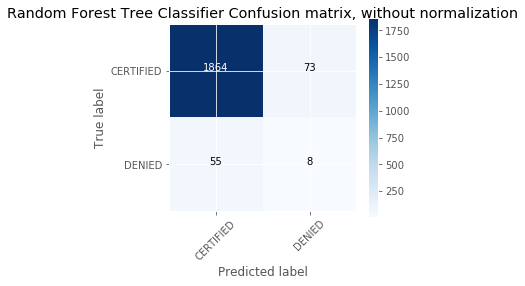

In [175]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_rf_smort_pca, classes=class_names,
                      title='Random Forest Tree Classifier Confusion matrix, without normalization')

Normalized confusion matrix
[[ 0.96  0.04]
 [ 0.87  0.13]]


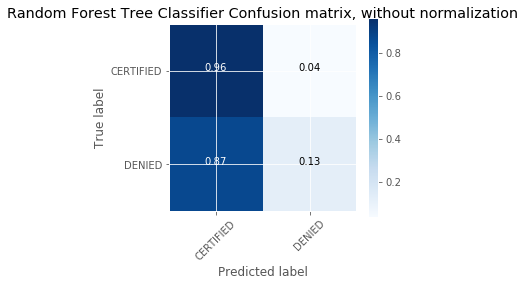

In [176]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_rf_smort_pca, classes=class_names,
                      title='Random Forest Tree Classifier Confusion matrix, without normalization',
                      normalize=True)

** ROC Curve **
____

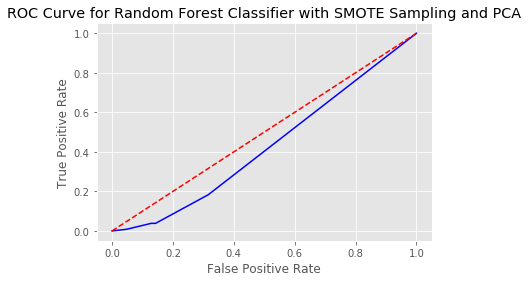

In [177]:
y_score_rf_smote_pca = rf_clf.predict_proba(X__pca_test)

# Evaluate classifier using and ROC Curve
fpr_rf_smote_pca, tpr_rf_smote_pca, thresholds_roc_rf_smote_pca = roc_curve(y_pca_test, 
                                                                         y_score_rf_smote_pca[:,1], 
                                                                         pos_label='CERTIFIED')


plt.plot(fpr_rf_smote_pca, tpr_rf_smote_pca, 'b-')
plt.plot([0, 1], [0, 1], 'r--')
plt.title("ROC Curve for Random Forest Classifier with SMOTE Sampling and PCA")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

    This is shows that the performance of this classifer with several Random Decision Trees actually performs less than a single decision tree classifier

** Precision Recall Curve **
____

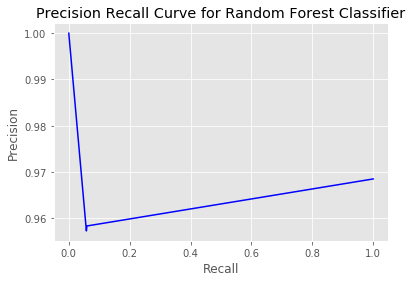

In [178]:
rf_precision, rf_recall, rf_threshold = precision_recall_curve(y_pca_test, 
                                                               y_score_rf_smote_pca[:,1],
                                                               pos_label="CERTIFIED")
plt.plot(dt_recall, dt_precision, 'b-')
plt.title("Precision Recall Curve for Random Forest Classifier")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

** Classification Report **
___

In [211]:
# Evaluate classifier with classification report
print(classification_report(y_pca_test, y_pred_rf_smote_pca))

             precision    recall  f1-score   support

  CERTIFIED       0.97      0.96      0.97      1937
     DENIED       0.10      0.13      0.11        63

avg / total       0.94      0.94      0.94      2000



** Precision Score **
___

In [210]:
cls_p_score_rf_smote_pca = precision_score(y_pca_test, y_pred_rf_smote_pca, pos_label="CERTIFIED")
print("Precision score is {:.2f}".format(cls_p_score_rf_smote_pca))

cls_r_score_rf_smote_pca = recall_score(y_pca_test, y_pred_rf_smote_pca, pos_label="CERTIFIED")
print("Recall Score is {:.2f}".format(cls_r_score_rf_smote_pca ))

Precision score is 0.97
Recall Score is 0.96


# Extra Trees Classifier
___

In [179]:
from sklearn.ensemble import ExtraTreesClassifier

In [187]:
et_clf = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)

In [188]:
et_clf2 = et_clf.fit(X_train_resampled_pca, y_train_resampled_pca)

In [202]:
# Get predicted Values
y_pred_et_smote_pca  = et_clf2.predict(X__pca_test)

** Confusion Matrix **
___

Confusion matrix, without normalization
[[1905   32]
 [  58    5]]


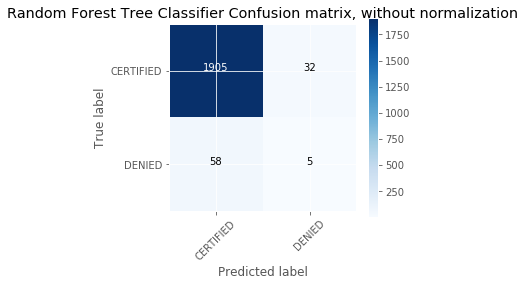

In [204]:
# Compute confusion matrix
cnf_matrix_et_smort_pca = confusion_matrix(y_pca_test, y_pred_et_smote_pca)
np.set_printoptions(precision=2)
class_names = ['CERTIFIED','DENIED']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_et_smort_pca, classes=class_names,
                      title='Random Forest Tree Classifier Confusion matrix, without normalization')
plt.show()


Normalized confusion matrix
[[ 0.98  0.02]
 [ 0.92  0.08]]


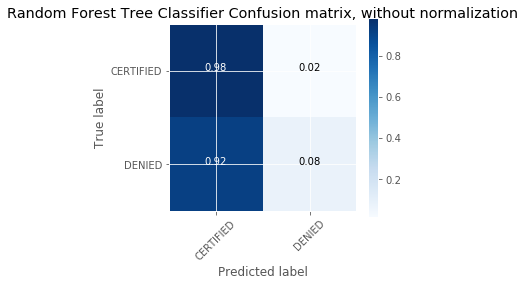

In [205]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_et_smort_pca, classes=class_names,
                      title='Random Forest Tree Classifier Confusion matrix, without normalization',
                      normalize=True)
plt.show()

** Classification Report **
___

In [208]:
# Evaluate classifier with classification report
print(classification_report(y_pca_test, y_pred_et_smote_pca))

             precision    recall  f1-score   support

  CERTIFIED       0.97      0.98      0.98      1937
     DENIED       0.14      0.08      0.10        63

avg / total       0.94      0.95      0.95      2000



** Precision and Recall Score **
___

In [209]:
cls_p_score_et_smote_pca = precision_score(y_pca_test, y_pred_et_smote_pca, pos_label="CERTIFIED")
print("Precision score is {:.2f}".format(cls_p_score_et_smote_pca))

cls_r_score_et_smote_pca = recall_score(y_pca_test, y_pred_et_smote_pca, pos_label="CERTIFIED")
print("Recall Score is {:.2f}".format(cls_r_score_et_smote_pca ))

Precision score is 0.97
Recall Score is 0.98


** ROC CURVE **
___

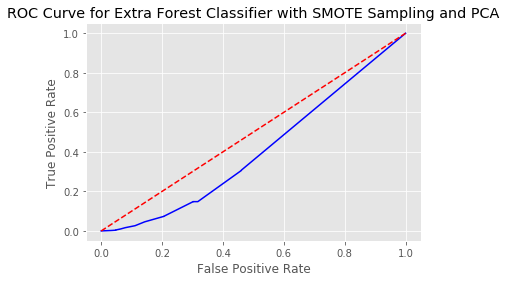

In [206]:
y_score_et_smote_pca = et_clf2.predict_proba(X__pca_test)

# Evaluate classifier using and ROC Curve
fpr_et_smote_pca, tpr_et_smote_pca, thresholds_roc_et_smote_pca = roc_curve(y_pca_test, 
                                                                         y_score_et_smote_pca[:,1], 
                                                                         pos_label='CERTIFIED')


plt.plot(fpr_et_smote_pca, tpr_et_smote_pca, 'b-')
plt.plot([0, 1], [0, 1], 'r--')
plt.title("ROC Curve for Extra Forest Classifier with SMOTE Sampling and PCA")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

** PRECISION - RECALL CURVE **
___

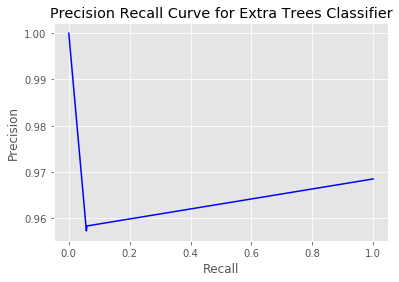

In [207]:
rf_precision, rf_recall, rf_threshold = precision_recall_curve(y_pca_test, 
                                                               y_score_rf_smote_pca[:,1],
                                                               pos_label="CERTIFIED")
plt.plot(dt_recall, dt_precision, 'b-')
plt.title("Precision Recall Curve for Extra Trees Classifier")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

** CROSS VAL SCORE **
___

In [183]:
from sklearn.model_selection import cross_val_score

In [199]:
scores = cross_val_score(et_clf, X_pca, y_vals, cv=5)

In [200]:
print(scores)

[ 0.96  0.96  0.96  0.96  0.96]


In [201]:
print(scores.mean())

0.961
